In [1]:
# -*-coding:utf-8-*-
# 调用所需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import *
import seaborn as sns
sns.set()

In [2]:
# 更改中文字体
# plt.rc(‘font’,family=[‘Microsoft YaHei’])

## 等额本金法

### 等额本金法计算公式
- 设贷款总额为A元，贷款年利率为R，月利率为i（i=R/12），贷款期限为n年，总期数为m个月（m=n×12） 
- 每月偿还本金 =  A/m
- 当月偿还利息 =  当月本金 * i      
- 当月本金 =  上月本金 -  上月偿还本金
- 当月偿还本利和 =  当月偿还本金 +  当月偿还利息
- 因此进行简单的循环即可得出所有的月付本息

In [3]:
def same_capital(K, r, n):
    '''
    参数 K:本金
    参数 r:年利率
    参数 n:贷款年数
    输出 x:包含了月份，每月本金，每月偿还利息，每月偿还总本息和的数据集
    '''
    # 计算月利率
    i = r / 12
    # 计算总的贷款月份
    m = 12 * n
    # 计算每月偿还本金额
    A = K / m
    # 构建一个空的DataFrame用于储存数据
    x = pd.DataFrame()
    x['月份'] = [j for j in range(1, m + 1)]
    x['当月本金'] = [K - A * j for j in range(m)]
    x['当月应付利息'] = np.nan
    x['当月应付本息和'] = np.nan
    # 为了循环的方便先填好第一行
    x.iloc[0, 2] = K * i
    x.iloc[0, 3] = A + K * i
    # 循环重复计算每月的利息和本息和
    for j in range(1, m):
        x.iloc[j, 2] = x.iloc[j, 1] * i
        x.iloc[j, 3] = A + x.iloc[j, 2]
    return x


### 等额本金法计算例子

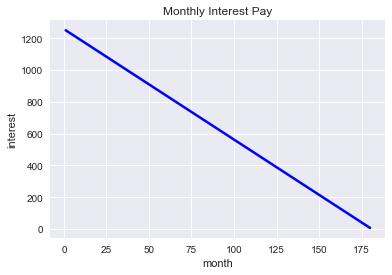

In [4]:
data = same_capital(300000, 0.05, 15)
plt.plot(data['月份'], data['当月应付利息'], color='blue', linewidth=2.5)
# 添加标题
plt.xlabel('month')
plt.ylabel('interest')
plt.title('Monthly Interest Pay')
plt.show()

可以看出每月还款的利息呈现下降趋势

## 等额本息法

### 等额本息法计算方法
- 首先我们可以把它看成是一种息票债券，现值为A，每月偿还x，一共偿还m期，月内部收益率等于月利率i
- 所以先求出月偿还总额：$x = \frac{Ai(1+i)^m}{(1+i)^m-1} $
- 将每月的还款日当作月末，则：
- 第一个月月初，本金为A，不需要还款；
- 第一个月的还款日（当作月末），本金A的本利和为A(1＋i)，还款X后，下个月的本金为：A(1＋i)-X；
- 第二个月月末，A(1＋i)-X的本金的本利和为：(A(1＋i)-X)(1＋i)，还款X后，下个月的本金为：(A(1＋i)-X)(1＋i)-X = A(1＋i)2-X[1+(1+i)]
- 可以进行等差数列求和，我们可以得到第k月的本金为：$A(1+i)^{(k-1)}-\frac{x[(1+i)^{k-1}-1]}{i}$
- 而第k月的应付的利息就为本金乘利率i：$[A(1+i)^{(k-1)}-\frac{x[(1+i)^{k-1}-1]}{i}]*i$
- 接着进行简单的循环即可得到债券每月的本金和利息变化情况

In [5]:
def same_interest(A, r, n):
    '''
    参数 A:本金
    参数 r:年利率
    参数 n:贷款年数
    输出 x:包含了月份，每月本金，每月偿还本金，每月偿还利息，每月偿还总金额的数据集
    '''
    # 计算月利率
    i = r / 12
    # 计算总的贷款月份
    m = 12 * n
    # 类比一个月付息债券，即可直接计算出每月的付款额
    monthly_pay = A * i * (1 + i) ** m / ((1 + i) ** m - 1)
    # 构建一个空的DataFrame用于储存数据
    x = pd.DataFrame()
    x['月份'] = [j for j in range(1, m + 1)]
    x['每月本金'] = np.nan
    x['每月偿还本金'] = np.nan
    x['每月偿还利息'] = np.nan
    x['每月偿还总金额'] = [monthly_pay for j in range(m)]
    for j in range(len(x)):
        # 计算处每月的本金额度
        x.iloc[j, 1] = A * (1 + i) ** j - monthly_pay * ((1 + i) ** j - 1) / i
        # 每月应付利息等于当月的本金额乘以月利率
        x.iloc[j, 3] = x.iloc[j, 1] * i
        # 由于月付本息和相等，减去利息即可得到偿还本金额度
        x.iloc[j, 2] = x.iloc[j, 4] - x.iloc[j, 3]
    return x

### 等额本息法例子

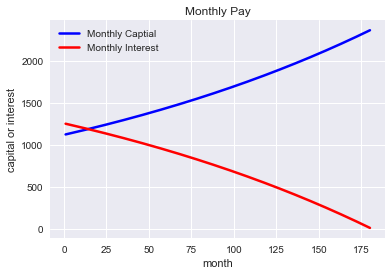

In [6]:
data = same_interest(300000, 0.05, 15)
# 选择画出两条曲线，即每月偿还本金和每月偿还利息
plt.plot(data['月份'], data['每月偿还本金'], color='blue', linewidth=2.5, label='Monthly Captial')
plt.plot(data['月份'], data['每月偿还利息'], color='red', linewidth=2.5, label='Monthly Interest')
# 添加标题
plt.title('Monthly Pay')
plt.xlabel('month')
plt.ylabel('capital or interest')
# 添加图例
plt.legend()
plt.show()

## 债券的凸性


### 债券的凸性计算公式
- 凸性的本质其实就是债券价格对市场利率的二阶导数
- $c = \frac{1}{p}\frac{d^2p}{dp^2}=\frac{1}{p(1+i)^2}[\sum_{t = t_1}^Tt(1+t)*\frac{coupon_t}{(1+i)^t}]$
- 经过n次循环即可求出结果

In [7]:
def convex(A, c, n, i):
    '''
        参数 A:票面价值
        参数 c:票面利率
        参数 n:债券期限
        参数 i:市场利率
    '''
    # 计算出息票值
    c = A * c
    # 用P去存储每期支付的现值
    P = 0
    # 用X去储存前n-1次循环使用息票的过程量，与最后一期分开计算
    X = 0
    for j in range(1, n):
        P += c / (1 + i) ** j
        X += j * (j + 1) * c / ((1 + i) ** j)
    # 最后一期因为要加上债券票面价值，所以单独拿出来计算
    P += (A + c) / (1 + i) ** n
    X += n * (n + 1) * (A + c) / ((1 + i) ** n)
    # 根据凸性的计算公式来计算即convex = 1/(P*(1+i)^2) * X
    con = 1 / (P * (1 + i) ** 2) * X
    print("经计算，对于一个票面价值为%s，票面利率为%0.2f%%，期限为%s年的债券，凸性为%s\n--------------------------------------------------------------------------------------------------"\
          %(A,c,n,con))


### 计算凸性例子

In [8]:
print('一组例子如下：\n')
convex(100, 0.07, 6, 0.1)
convex(100, 0.09, 7, 0.1)
convex(100, 0.14, 9, 0.1)
convex(100, 0.16, 8, 0.1)
convex(100, 0.18, 9, 0.1)

一组例子如下：

经计算，对于一个票面价值为100，票面利率为7.00%，期限为6年的债券，凸性为27.31532119908074
--------------------------------------------------------------------------------------------------
经计算，对于一个票面价值为100，票面利率为9.00%，期限为7年的债券，凸性为32.8245941955813
--------------------------------------------------------------------------------------------------
经计算，对于一个票面价值为100，票面利率为14.00%，期限为9年的债券，凸性为41.839736076811185
--------------------------------------------------------------------------------------------------
经计算，对于一个票面价值为100，票面利率为16.00%，期限为8年的债券，凸性为34.46203357957334
--------------------------------------------------------------------------------------------------
经计算，对于一个票面价值为100，票面利率为18.00%，期限为9年的债券，凸性为39.14042134957644
--------------------------------------------------------------------------------------------------


## 利率期限结构

### 利率期限结构计算公式
- 利率期限结构是指在某一时点上，不同期限资金的收益率与到期期限之间的关系。
- 对于操作而言，其实就是根据已知的即期利率，去计算更远期限的即期利率，是一个从前往后不断推进的过程
- 需要注意的是一年之内的所有债券的即期利率就是到期收益率，所以可以直接相等
- 为了方便起见我默认使用的债券数据都是一年付息两次，传入的数据集里默认已经有债券基本信息包括到期收益率
- 列举其中2步计算过程(因为半年和一年是直接相等，所以从1.5年开始计算)：
    - $r_1 = YTM_{0.5}$
    - $r_2 = YTM_1$
    - $par=\frac{coupon}{1+r_1/2}+\frac{coupon}{(1+r_2/2)^2}+\frac{coupon+par}{(1+r_3/2)^3}$ 
    - 其中par为面值，coupon为第1.5年的现金流，带入$r_1$和$r_2$求解出$r_{3}$即为1.5年的即期利率
    - $par=\frac{coupon}{1+r_1/2}+\frac{coupon}{(1+r_2/2)^2}+\frac{coupon}{(1+r_3/2)^3}+\frac{coupon+par}{(1+r_4/2)^4}$ 
    - 于是带入之前的r，求出第二年的即期利率即可
    - 重复上述过程，最后便能求得利率期限结构

In [9]:
def IRR(data):
    data['即期收益率'] = np.nan
    # 一年期内的到期利率即为即期利率
    data.iloc[0, 3] = data.iloc[0, 2]
    data.iloc[1, 3] = data.iloc[1, 2]
    for i in range(2, len(data)):
        # 将即期收益率设为x
        x = symbols('x')
        # 计算息票值，因为百分数所以除以100
        coupon = data.iloc[i, 0] * data.iloc[i, 1] / 100
        # 用p来储存前面n-1期的现金流贴现总和
        p = 0
        for j in range(i):
            p += coupon / ((1 + data.iloc[j, 3] / 200) ** (j + 1))
        # 使用Sympy的solve函数直接接触即期利率
        a = solve(data.iloc[i, 0] - p - ((data.iloc[i, 0] + coupon) / ((1 + x / 2) ** (i + 1))), x)
        # 因为会解出复数解，所以根据类型筛选数据后取其中最大的实数字作为即期利率
        r = max([x for x in a if type(x) == Float])
        # 将半年的名义利率转换为一年的，如有需要可以更改为实际利率，但要与之前一起更改
        data.iloc[i, 3] = r * 100
    return data


### 利率期限结构简单例子

In [10]:
# 生成一组原始数据
data = pd.DataFrame()
data['债券期限'] = [0.5, 1, 1.5, 2, 2.5, 3]
x = data['债券期限'] = [0.5, 1, 1.5, 2, 2.5, 3]
data['债券初始面值'] = [100, 100, 100, 100, 100, 100]
data['票面利率'] = [1.9, 2.1, 2.3, 2.8, 3.7, 5.5]
data['到期收益率'] = [4.0, 4.2, 4.6, 5.6, 5.8, 7.0]
data.set_index('债券期限', inplace=True)
# 计算这组数据的利率期限结构
result = IRR(data)
result

,债券初始面值,票面利率,到期收益率,即期收益率
债券期限,,,,
0.5,100,1.9,4.0,4
1.0,100,2.1,4.2,4.2
1.5,100,2.3,4.6,4.61087216259755
2.0,100,2.8,5.6,5.65329297457169
2.5,100,3.7,5.8,7.60002114620885
3.0,100,5.5,7.0,11.8398918196558


### 利率期限结构图

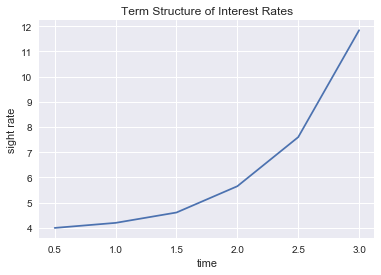

In [11]:
plt.plot(x,data['即期收益率'])
plt.title('Term Structure of Interest Rates')
plt.xlabel('time')
plt.ylabel('sight rate')
plt.show()

通常如果计算市场的利率期限结构，我会选择使用 MATLAB 金融工具箱中的 zbtyield 函数，较为方便